# References

Medical neural networks:
https://glassboxmedicine.com/

Comparison of ResNet50 and VGG19 and training from stratch for X-ray images dataset:
https://www.sciencedirect.com/science/article/pii/S2666285X21000558

Tensorboard confusion matrix:
https://towardsdatascience.com/exploring-confusion-matrix-evolution-on-tensorboard-e66b39f4ac12

Pre-processing and modeling pipelines (ResNet50):
https://towardsdatascience.com/time-to-choose-tensorflow-data-over-imagedatagenerator-215e594f2435

Image data input pipelines:
https://towardsdatascience.com/what-is-the-best-input-pipeline-to-train-image-classification-models-with-tf-keras-eb3fe26d3cc5

Split TF datasets:
https://towardsdatascience.com/how-to-split-a-tensorflow-dataset-into-train-validation-and-test-sets-526c8dd29438

Transfer learning with EfficientNet:
https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/

Training greyscale images using transfer learning:
https://stackoverflow.com/questions/51995977/how-can-i-use-a-pre-trained-neural-network-with-grayscale-images

Multi-label vs multi-class classification:
https://glassboxmedicine.com/2019/05/26/classification-sigmoid-vs-softmax/

Element-wise sigmoid:
https://www.programcreek.com/python/example/93769/keras.backend.sigmoid

Element-wise sigmoid:
https://stackoverflow.com/questions/52090857/how-to-apply-sigmoid-function-for-each-outputs-in-keras

# Setup

### Install packages

In [21]:
# Install additional packages

!pip install tf_keras_vis

In [63]:
import os
import pathlib
import re
from glob import glob
import random
import time
import zipfile
import imageio
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import time
from itertools import islice, count
import warnings
warnings.simplefilter('ignore')
plt.style.use('seaborn-notebook')
sns.set_style('darkgrid')

from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import backend as K
from tensorflow.keras.backend import clear_session
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Activation, Input 
from tensorflow.keras.layers import GlobalMaxPooling2D, GlobalAveragePooling2D, Flatten
from tensorflow.keras.layers import BatchNormalization, GaussianNoise
from tensorflow.keras.layers.experimental.preprocessing import RandomRotation, RandomZoom, RandomTranslation
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.metrics import AUC
from tensorflow.keras.optimizers import Adam, Adamax, Nadam, SGD, Adagrad, RMSprop
from tensorflow.keras.regularizers import l1_l2, l1, l2
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.initializers import he_normal, glorot_normal
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K 
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.saliency import Saliency

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

### Check GPU and CPU instances

In [23]:
# Enable/Disable Eager Execution
# Reference: https://www.tensorflow.org/guide/eager
# TensorFlow's eager execution is an imperative programming environment
# that evaluates operations immediately, without building graphs

#tf.compat.v1.disable_eager_execution()
#tf.compat.v1.enable_eager_execution()

print(f"tensorflow version {tf.__version__}")
print(f"keras version {tf.keras.__version__}")
print(f"Eager Execution Enabled: {tf.executing_eagerly()}\n")

# Get the number of replicas 
strategy = tf.distribute.MirroredStrategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

devices = tf.config.experimental.get_visible_devices()
print("Devices:", devices)
print(tf.config.experimental.list_logical_devices('GPU'))

print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("All Physical Devices", tf.config.list_physical_devices())

# Better performance with the tf.data API
# Reference: https://www.tensorflow.org/guide/data_performance
AUTOTUNE = tf.data.experimental.AUTOTUNE

tensorflow version 2.8.0
keras version 2.8.0
Eager Execution Enabled: True

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of replicas: 1
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
All Physical Devices [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [24]:
# Check which GPU is assigned to the session
!nvidia-smi

Mon May  2 15:00:57 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    32W / 250W |    377MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Set seeds and mount Google Drive

In [25]:
# Ensure replicable results
import os
import random as rn
SEED = 109
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = '0'
os.environ['CUDA_VISIBLE_DEVICES'] = ''
tf.random.set_seed(SEED)
np.random.seed(SEED)
rn.seed(SEED)

In [26]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Path to Google Drive
base_path = '/content/drive/My Drive/cs109b_final_project/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Preprocessing

### Load image data into TF datasets

In [27]:
# Get image filenames

# Path to images
images_path = base_path + 'images_rescaled_subsample'

# Filenames with full absolute paths
images_filenames_full_path = glob(images_path + '/*')

# Sort to be consistent
images_filenames_full_path.sort()

# Get terminal filenames
images_filenames = [re.sub('^(.*[/])', '', x) for x in images_filenames_full_path]

In [28]:
# Function to load the image data into TF datasets

def make_tf_image_dataset(filenames, image_size):

  def parse_image(filename):
    image = tf.io.read_file(filename)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    return image

  filenames_ds = tf.data.Dataset.from_tensor_slices(filenames)
  images_ds = filenames_ds.map(parse_image, num_parallel_calls=AUTOTUNE)

  return images_ds

In [29]:
# Load the image and label data into TF datasets
# NOTE: this will load the grayscale image repeated 3 times (i.e., 3 channels)

IMG_SIZE = 256

images_ds = make_tf_image_dataset(filenames=images_filenames_full_path, image_size=IMG_SIZE)

print("images_ds shape: ", images_ds)
print("number of images parsed: ", images_ds.cardinality().numpy())

images_ds shape:  <ParallelMapDataset element_spec=TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None)>
number of images parsed:  1100


### Load label data into TF datasets

#### From "train_relabeled.csv" and "valid_relabeled.csv"

In [ ]:
# # Load label data from "train_relabeled.csv" and "valid_relabeled.csv"

# # Limit scope to 8 diseases in original paper
# columns_to_keep = ['Path', 'Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax']

# # Load "train_relabeled.csv" and "valid_relabeled.csv"
# train_labels_df = pd.read_csv(google_drive_path + 'label_data/train_relabeled.csv')[columns_to_keep]
# valid_labels_df = pd.read_csv(google_drive_path + 'label_data/valid_relabeled.csv')[columns_to_keep]

# # Examine first 5 rows of training dataframe
# print(f'Shape of train_labels_df: {train_labels_df.shape}')
# display(train_labels_df.head())

# # Examine first 5 rows of validation dataframe
# print(f'Shape of valid_labels_df: {valid_labels_df.shape}')
# display(valid_labels_df.head())

# # Stack the two DataFrames
# labels_df = pd.concat([train_labels_df, valid_labels_df], ignore_index=True, axis=0)

# # Remove the 'images/' prefix from the Path column
# labels_df['Path'] = labels_df['Path'].apply(lambda x: re.sub('^(.*[/])', '', x))

# # Examine first 5 rows of combined dataframe
# print(f'Shape of labels_df: {labels_df.shape}')
# display(labels_df.head())

#### From "Data_Entry_2017_v2020.csv"

In [30]:
# Load Data_Entry_2017_v2020.csv

labels_path = base_path + 'meta_data/Data_Entry_2017_v2020.csv'
data_entry_df = pd.read_csv(labels_path)

# Examine first 5 rows of dataframe
print(f'Shape of data_entry_df: {data_entry_df.shape}')
display(data_entry_df.head())

Shape of data_entry_df: (112120, 11)


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,0.171
4,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,0.168


In [31]:
# Determine the number of unique label combinations
disease_combinations = data_entry_df['Finding Labels'].unique()
print(f'Number of unique disease combinations: {len(disease_combinations)}\n')

# Split up disease_combinations into individual diseases - get number of unique labels
disease_combinations_split = [combination.split('|') for combination in disease_combinations]
diseases = list(set([disease for observation in disease_combinations_split for disease in observation]))

# Sanity check - how many unique diseases are present in the data
print(f'Number of unique diseases (including No Finding): {len(diseases)}\n')
print('Unique diseases (including No Finding): \n')
for disease in diseases:
  print(disease)

Number of unique disease combinations: 836

Number of unique diseases (including No Finding): 15

Unique diseases (including No Finding): 

Pleural_Thickening
Effusion
No Finding
Atelectasis
Infiltration
Pneumothorax
Fibrosis
Pneumonia
Nodule
Consolidation
Edema
Hernia
Cardiomegaly
Emphysema
Mass


In [32]:
# One hot encode label data

# Rename image column
data_entry_df = data_entry_df.rename({'Image Index': 'image_filename'}, axis=1)

# Limit scope to 8 diseases in original paper plus 'No Finding'
diseases_to_keep = ['No Finding', 'Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax']
diseases = [disease for disease in diseases if disease in diseases_to_keep]

# Helper function to create one-hot encoded dataframe
@np.vectorize
def one_hot_disease(label, disease='No Finding'):
  if disease in label:
    return 1
  return 0

# Create one-hot encoded dataframe
one_hot_disease_df = data_entry_df[['image_filename']]
for disease in diseases:
  one_hot_disease_df[disease] = one_hot_disease(data_entry_df['Finding Labels'], disease=disease)

# Rename no finding column
one_hot_disease_df = one_hot_disease_df.rename({'No Finding': 'No_Finding'}, axis=1)

# Save results
one_hot_disease_df.to_csv(base_path + 'output/one_hot_data_entry.csv', index=False)

# Examine first 5 rows of one_hot_disease_df dataframe
print(f'Shape of one_hot_disease_df: {one_hot_disease_df.shape}')
display(one_hot_disease_df.head())

Shape of one_hot_disease_df: (112120, 10)


,image_filename,Effusion,No_Finding,Atelectasis,Infiltration,Pneumothorax,Pneumonia,Nodule,Cardiomegaly,Mass
0,00000001_000.png,0,0,0,0,0,0,0,1,0
1,00000001_001.png,0,0,0,0,0,0,0,1,0
2,00000001_002.png,1,0,0,0,0,0,0,1,0
3,00000002_000.png,0,1,0,0,0,0,0,0,0
4,00000003_001.png,0,0,0,0,0,0,0,0,0


In [33]:
# Subset labels_df to include only subsample

# Logically index labels_df based on subsample filenames
labels_subsample_df = one_hot_disease_df[one_hot_disease_df['image_filename'].isin(images_filenames)]

# Reorder labels to match image order
labels_subsample_df = labels_subsample_df.sort_values('image_filename') 

# Examine first 5 rows of labels_subsample_df dataframe
print(f'Shape of labels_subsample_df: {labels_subsample_df.shape}')
display(labels_subsample_df.head())

Shape of labels_subsample_df: (1100, 10)


,image_filename,Effusion,No_Finding,Atelectasis,Infiltration,Pneumothorax,Pneumonia,Nodule,Cardiomegaly,Mass
151,00000032_037.png,0,0,0,1,0,0,0,1,0
310,00000072_000.png,0,0,1,0,0,0,0,0,0
596,00000147_001.png,0,0,1,0,0,0,0,0,0
608,00000149_006.png,0,0,1,0,0,0,0,0,0
614,00000150_002.png,0,0,1,1,0,1,0,0,0


In [34]:
# Convert labels to TF dataset

# Create label ds
labels_ds = tf.data.Dataset.from_tensor_slices(labels_subsample_df.drop(columns='image_filename'))   

print("labels_ds shape: ", labels_ds)
print("number of labels parsed: ", labels_ds.cardinality().numpy())   

labels_ds shape:  <TensorSliceDataset element_spec=TensorSpec(shape=(9,), dtype=tf.int64, name=None)>
number of labels parsed:  1100


### Combine images and labels

In [35]:
# Zip together the image and label data into one TF dataset

complete_ds = tf.data.Dataset.zip((images_ds, labels_ds))
complete_ds

<ZipDataset element_spec=(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(9,), dtype=tf.int64, name=None))>

### Partition TF datasets into training and validation sets

In [36]:
# Function to partition the TF datasets into Training and Validation sets

def partition_tf_data(ds, ds_size, train_split=0.8, val_split=0.2, 
                      test_split=0, shuffle=True, shuffle_size=10000):
  
    # assert(train_split + test_split + val_split) == 1
    assert(train_split + val_split) == 1
    
    if shuffle:
        # Specify seed to always have the same split distribution between runs
        ds = ds.shuffle(shuffle_size, seed=109)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    # test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds #, test_ds

In [37]:
# Partition the TF datasets

DS_SIZE = images_ds.cardinality().numpy()

train_ds, val_ds = partition_tf_data(ds=complete_ds, ds_size=DS_SIZE)

print("Train shape: ", train_ds)
print("Validation shape: ", val_ds)
print("number of training images/labels: ", train_ds.cardinality().numpy())
print("number of validation images/labels: ", val_ds.cardinality().numpy())

Train shape:  <TakeDataset element_spec=(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(9,), dtype=tf.int64, name=None))>
Validation shape:  <TakeDataset element_spec=(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(9,), dtype=tf.int64, name=None))>
number of training images/labels:  880
number of validation images/labels:  220


### Batching

In [38]:
# Set up batches

BATCH_SIZE_TRAIN = 32
BATCH_SIZE_VAL = 32

train_ds_batches = train_ds.shuffle(buffer_size=40000).batch(BATCH_SIZE_TRAIN).prefetch(buffer_size=AUTOTUNE)
val_ds_batches = val_ds.batch(BATCH_SIZE_VAL).prefetch(buffer_size=AUTOTUNE)

print("Train shape: ", train_ds_batches)
print("Validation shape: ", val_ds_batches)

Train shape:  <PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 9), dtype=tf.int64, name=None))>
Validation shape:  <PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 9), dtype=tf.int64, name=None))>


### Preprocessing layers

In [40]:
# Pre-processing layers

# Rescale pixels
rescale_layer = Sequential([layers.experimental.preprocessing.Rescaling(1./255)])

# Data augmentation
data_augmentation_layer = Sequential([
  RandomRotation(0.2), 
  RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3)),
  RandomTranslation(0.3, 0.3, fill_mode='reflect', interpolation='bilinear',)
])

# Model Training


### Callbacks

In [41]:
# Callbacks

# Early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    mode='min', 
    min_delta=0.1, 
    patience=10, 
    restore_best_weights=True, 
    verbose=True)

# Reduce learning rate by factor of 0.5 if val_coef_determination does not improve within 3 epochs
reduce_lrt_plateau = ReduceLROnPlateau(
    monitor='val_loss', 
    mode='min',
    min_delta=0.2,
    factor=0.5,
    patience=3, 
    min_lr=1e-6,
    verbose=2)

# This function keeps the initial learning rate for the first 7 epochs and decreases it exponentially after that
def scheduler(epoch, lr):
    if epoch <= 7:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lrt_scheduler = LearningRateScheduler(scheduler)

### Model architecture

Which model to use for transfer learning?

- ResNet (50, 18)
- VGG (16, 19)
- EfficientNet (B0, B1, B2, B3, B4, B5, B6, B7)

In [44]:
# Define model architecture

IMG_SIZE = 256

def create_model(transfer_model='ResNet50'):
  # Transfer models
  if transfer_model=='ResNet50': # default input shape 224x224
      transfer_layer = ResNet50(include_top=False, weights='imagenet', 
                                input_shape=(IMG_SIZE, IMG_SIZE, 3))
  elif transfer_model=='EfficientNetB0': # default input shape 224x224
      transfer_layer = EfficientNetB0(include_top=False, weights="imagenet",
                                      input_shape=(IMG_SIZE, IMG_SIZE, 3))
  elif transfer_model=='VGG16': # default input shape 224x224
      transfer_layer = VGG16(include_top=False, weights="imagenet",
                             input_shape=(IMG_SIZE, IMG_SIZE, 3))
  elif transfer_model=='VGG19': # default input shape 224x224
      transfer_layer = VGG19(include_top=False, weights="imagenet", 
                             input_shape=(IMG_SIZE, IMG_SIZE, 3))
  elif transfer_model=='DenseNet121': # default input shape 224x224
      transfer_layer = DenseNet121(include_top=False, weights="imagenet", 
                                   input_shape=(IMG_SIZE, IMG_SIZE, 3))

      
  # Inputs, Preprocessing, and Transfer layers
  inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
  rescale = rescale_layer(inputs)
  augmented = data_augmentation_layer(rescale)
  transfer = transfer_layer(augmented)
  # TRY STUFF HERE

  # Pool for dense output
  pooling = GlobalAveragePooling2D()(transfer)
  dropout = Dropout(0.4)(pooling)
  # TRY STUFF HERE
  
  # Output layer
  outputs = Dense(9, activation='sigmoid')(dropout)  
  model = Model(inputs=inputs, outputs=outputs)
  return model

clear_session()
base_model = create_model(transfer_model='DenseNet121')
base_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential_4 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 sequential_5 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 densenet121 (Functional)    (None, 8, 8, 1024)        7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                             

### Compile

In [45]:
# Compile

# Optimizers
opt = Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

# Compile model
base_model.compile(
    optimizer=opt, 
    loss='binary_crossentropy', 
    metrics=['AUC'])

### Train

In [46]:
# Train the model

# Parameters
EPOCHS = 50 

# Training
history = base_model.fit(
    x=train_ds_batches,  
    validation_data=val_ds_batches,
    epochs=EPOCHS,  
    verbose=1,
    use_multiprocessing=True, 
    callbacks=[early_stop, reduce_lrt_plateau, lrt_scheduler]
    )

%time

Epoch 1/50
28/28 [==============================] - 155s 506ms/step - loss: 0.5425 - auc: 0.5727 - val_loss: 1.7193 - val_auc: 0.5351 - lr: 0.0010
Epoch 2/50
28/28 [==============================] - 13s 381ms/step - loss: 0.5032 - auc: 0.5971 - val_loss: 1.6349 - val_auc: 0.4431 - lr: 0.0010
Epoch 3/50
28/28 [==============================] - 13s 387ms/step - loss: 0.4885 - auc: 0.6191 - val_loss: 0.6565 - val_auc: 0.5514 - lr: 0.0010
Epoch 4/50
28/28 [==============================] - 13s 387ms/step - loss: 0.4876 - auc: 0.6307 - val_loss: 0.4964 - val_auc: 0.6044 - lr: 0.0010
Epoch 5/50
28/28 [==============================] - 13s 380ms/step - loss: 0.4816 - auc: 0.6370 - val_loss: 0.5670 - val_auc: 0.5941 - lr: 0.0010
Epoch 6/50
28/28 [==============================] - ETA: 0s - loss: 0.4799 - auc: 0.6438
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
28/28 [==============================] - 13s 383ms/step - loss: 0.4799 - auc: 0.6438 - val_loss: 1.1636 

### Save / Load model

In [47]:
# Save model
base_model.save(base_path + 'output/base_model')

INFO:tensorflow:Assets written to: /content/drive/My Drive/cs109b_final_project/output/base_model/assets


In [ ]:
# Load model
base_model = load_model(base_path + 'output/base_model')

# Model Evaluation

### Plot history

In [48]:
def plot_history(model, title:str=''):
    """Create plots for the training history"""
    
    h = model.history.history
    y1 = h['auc']
    y2 = h['val_auc']
    y3 = h['loss']
    y4 = h['val_loss']

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))

    x = model.history.epoch
    ax1.plot(x, y1, label='train', linewidth=2)
    ax1.plot(x, y2, label='validation', linewidth=2)
    ax1.set_title('AUC-ROC', fontsize=20)
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('AUC-ROC')
    best_auc = np.nanmax(y2)
    ax1.axvline(np.nanargmax(y2),
                ls='--', label=f'best val auc = {best_auc:.2f}')
    ax1.grid(True)
    ax1.legend()

    ax2.plot(x, y3, label='train', linewidth=2)
    ax2.plot(x, y4, label='validation', linewidth=2)
    ax2.set_title('Loss', fontsize=20)
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    best_loss = np.nanmin(y4)
    ax2.axvline(np.nanargmin(y4),
                ls='--', label=f'best val loss = {best_loss:.2f}')
    ax2.grid(True)
    ax2.legend()

    fig.suptitle(title, fontsize=12)

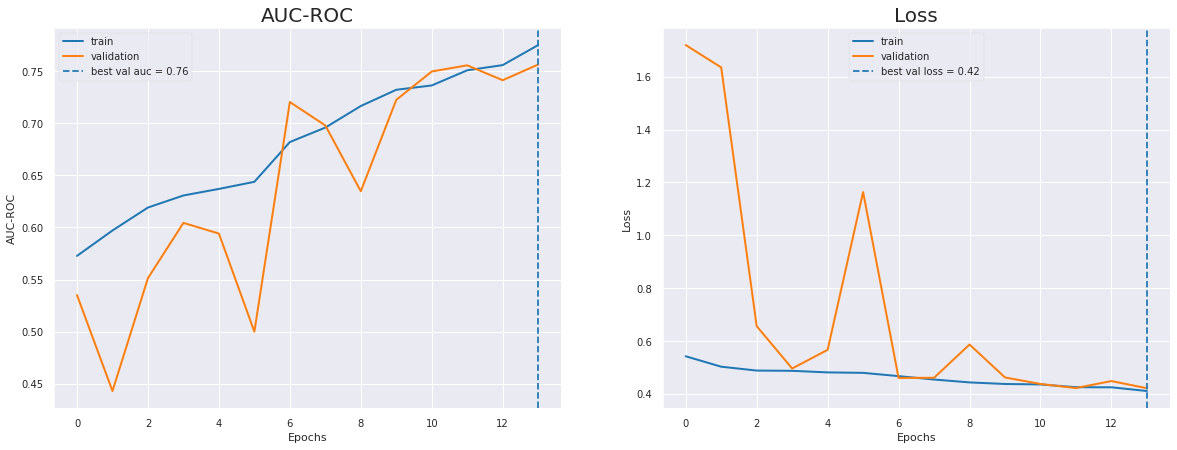

In [49]:
# Plot training loss
plot_history(base_model)

### Performance metrics

How to set up a confusion matrix from a prefetched TF dataset?

In [58]:
class_labels = one_hot_disease_df.columns[1:]

In [59]:
# Predict on the test set
pred = base_model.predict(val_ds_batches)
print(pred)

pred_df = pd.DataFrame(pred, columns=class_labels)
pred_df.to_csv('/content/drive/My Drive/pred.csv')
print(pred_df.head(100))

[[0.42405072 0.20051928 0.38118157 ... 0.1104603  0.29259783 0.0933697 ]
 [0.41212714 0.16734093 0.38461193 ... 0.1059629  0.32251397 0.1027045 ]
 [0.3263923  0.36608014 0.25011364 ... 0.08854916 0.25662658 0.07048173]
 ...
 [0.4415993  0.13996965 0.40232885 ... 0.08840099 0.33078936 0.10674989]
 [0.43023947 0.20032012 0.38772368 ... 0.10343453 0.30516246 0.09349921]
 [0.38513306 0.2275521  0.3280238  ... 0.09841415 0.28272846 0.09476414]]
    Effusion  No_Finding  Atelectasis  Infiltration  Pneumothorax  Pneumonia  \
0   0.424051    0.200519     0.381182      0.294590      0.133530   0.195127   
1   0.412127    0.167341     0.384612      0.316988      0.131036   0.200977   
2   0.326392    0.366080     0.250114      0.191235      0.086026   0.132954   
3   0.503996    0.121556     0.404582      0.381222      0.175733   0.216006   
4   0.419527    0.172467     0.405951      0.307153      0.141622   0.208695   
..       ...         ...          ...           ...           ...        ...

In [60]:
# Get classes from prefetched TF dataset

# https://stackoverflow.com/questions/64622210/how-to-extract-classes-from-prefetched-dataset-in-tensorflow-for-confusion-matri


y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in val_ds_batches:  # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = base_model.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = -1)) #### SET UP FOR SOFTMAX

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

In [61]:
correct_labels_arrary = correct_labels.numpy()
correct_labels_df = pd.DataFrame(correct_labels_arrary, columns=class_labels)
print(correct_labels_df.head(100))

    Effusion  No_Finding  Atelectasis  Infiltration  Pneumothorax  Pneumonia  \
0          0           0            0             0             0          0   
1          0           0            1             0             1          0   
2          0           0            0             0             0          0   
3          0           0            0             1             0          1   
4          0           1            0             0             0          0   
..       ...         ...          ...           ...           ...        ...   
95         0           0            1             0             0          0   
96         0           0            0             1             0          1   
97         0           0            0             0             0          1   
98         0           1            0             0             0          0   
99         1           0            0             0             0          0   

    Nodule  Cardiomegaly  Mass  
0     

In [73]:
def get_performance_metrics(y_df, pred_df, th, class_name):
  y = y_df[class_name].values
  pred = pred_df[class_name].values

  def true_positives(y, pred, th):
    TP = 0
    # get thresholded predictions
    thresholded_preds = pred >= th
    # compute TP
    TP = np.sum((y == 1) & (thresholded_preds == 1))
    return TP

  def true_negatives(y, pred, th):
    TN = 0
    # get thresholded predictions
    thresholded_preds = pred >= th
    # compute TN
    TN = np.sum((y == 0) & (thresholded_preds == 0))
    return TN

  def false_positives(y, pred, th):
    FP = 0
    # get thresholded predictions
    thresholded_preds = pred >= th
    # compute FP
    FP = np.sum((y == 0) & (thresholded_preds == 1)) 
    return FP

  def false_negatives(y, pred, th):
    FN = 0
    # get thresholded predictions
    thresholded_preds = pred >= th    
    # compute FN
    FN = np.sum((y == 1) & (thresholded_preds == 0))  
    return FN

  def get_accuracy(y, pred, th):
    accuracy = 0.0
    # get TP, FP, TN, FN using our previously defined functions
    TP = true_positives(y, pred, th)
    TN = true_negatives(y, pred, th)
    FP = false_positives(y, pred, th)
    FN = false_negatives(y, pred, th)
    # Compute accuracy using TP, FP, TN, FN
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    return accuracy

  def get_prevalence(y):
    prevalence = 0.0
    prevalence = np.sum(y == 1) / len(y) 
    return prevalence

  def get_sensitivity(y, pred, th):
    sensitivity = 0.0
    # get TP and FN using our previously defined functions
    TP = true_positives(y, pred, th)
    FN = false_negatives(y, pred, th)
    # use TP and FN to compute sensitivity
    sensitivity = TP / (TP + FN)
    return sensitivity

  def get_specificity(y, pred, th):
    specificity = 0.0
    # get TN and FP using our previously defined functions
    TN = true_negatives(y, pred, th)
    FP = false_positives(y, pred, th)
    # use TN and FP to compute specificity 
    specificity = TN / (TN + FP)
    return specificity

  def get_ppv(y, pred, th):
    PPV = 0.0
    # get TP and FP using our previously defined functions
    TP = true_positives(y, pred, th)
    FP = false_positives(y, pred, th)
    # use TP and FP to compute PPV
    PPV = TP / (TP + FP)
    return PPV

  def get_npv(y, pred, th):
    NPV = 0.0
    # get TN and FN using our previously defined functions
    TN = true_negatives(y, pred, th)
    FN = false_negatives(y, pred, th)
    # use TN and FN to compute NPV
    NPV = TN / (TN + FN)
    return NPV

  def get_ROC_curve(y, pred):
    fpr, tpr, _ = sklearn.metrics.roc_curve(y,  pred)
    #create ROC curve
    plt.plot(fpr,tpr)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

  def get_roc_auc(y, pred):
    return sklearn.metrics.roc_auc_score(y, pred)

  def print_confidence_intervals(class_name, statistics):
    print("CI for disease {} roc_auc_score:".format(class_name))
    print(np.percentile(statistics, 2.5), np.percentile(statistics, 97.5))

  def bootstrap_auc(y, pred, class_name, bootstraps, fold_size):
    statistics = np.zeros((1, bootstraps))
    df = pd.DataFrame(columns=['y', 'pred'])
    df.loc[:, 'y'] = y_df[class_name]
    df.loc[:, 'pred'] = pred_df[class_name]
    # get positive examples for stratified sampling
    df_pos = df[df.y == 1]
    df_neg = df[df.y == 0]
    prevalence = len(df_pos) / len(df)
    for i in range(bootstraps):
      # stratified sampling of positive and negative examples
      pos_sample = df_pos.sample(n = int(fold_size * prevalence), replace=True)
      neg_sample = df_neg.sample(n = int(fold_size * (1-prevalence)), replace=True)

      y_sample = np.concatenate([pos_sample.y.values, neg_sample.y.values])
      pred_sample = np.concatenate([pos_sample.pred.values, neg_sample.pred.values])
      score = sklearn.metrics.roc_auc_score(y_sample, pred_sample)
      statistics[0][i] = score
    print_confidence_intervals(class_name, statistics)

  def get_PRC_curve(y, pred):
    p, r, t = sklearn.metrics.precision_recall_curve(y, pred)
    #create PRC curve
    plt.plot(r,p)
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    plt.show()
    
  def get_ap_score(y, pred):
    return sklearn.metrics.average_precision_score(y, pred)

  def get_f1(y, pred):
    precision = get_ppv(y, pred, th)
    recall = get_sensitivity(y, pred, th)
    F1 = 2 * (precision * recall) / (precision + recall)
    return F1

  accuracy = get_accuracy(y, pred, th)
  print('accuracy: {}'.format(accuracy))
  prevalence = get_prevalence(y)
  print('prevalence: {}'.format(prevalence))
  sensitivity = get_sensitivity(y, pred, th)
  print('sensitivity: {}'.format(sensitivity))
  specificity = get_specificity(y, pred, th)
  print('specificity: {}'.format(specificity))
  ppv = get_ppv(y, pred, th)
  print('ppv: {}'.format(ppv))
  npv = get_npv(y, pred, th)
  print('npv: {}'.format(npv))
  print("ROC Curve")
  get_ROC_curve(y, pred)
  roc_auc = get_roc_auc(y, pred)
  print('roc_auc: {}'.format(roc_auc))
  bootstrap_auc(y, pred, class_name, bootstraps = 100, fold_size = len(y))
  print("PRC Curve")
  get_PRC_curve(y, pred)
  ap_score = get_ap_score(y, pred)   
  print('ap_score: {}'.format(ap_score))
  f1_score = get_f1(y, pred)
  print('f1_score: {}'.format(f1_score))

  return accuracy, prevalence, sensitivity, specificity, ppv, npv, roc_auc, ap_score, f1_score   

In [74]:
metrics_dict = dict()
class_list = list()
accuracy_list = list()
prevalence_list = list() 
sensitivity_list = list() 
specificity_list = list() 
ppv_list = list() 
npv_list = list() 
roc_auc_list = list() 
ap_score_list = list() 
f1_score_list = list()

n/Evaluation metrics for disease Effusion
accuracy: 0.7181818181818181
prevalence: 0.2545454545454545
sensitivity: 0.05357142857142857
specificity: 0.9451219512195121
ppv: 0.25
npv: 0.7451923076923077
ROC Curve


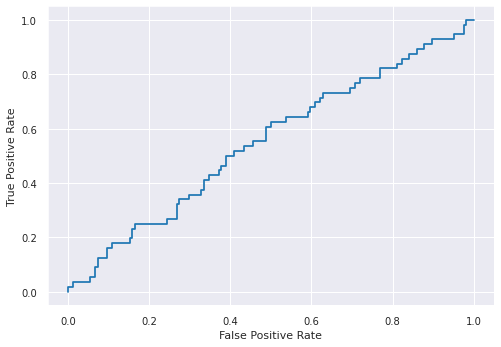

roc_auc: 0.5484538327526132
CI for disease Effusion roc_auc_score:
0.44803769401330373 0.6303464523281596
PRC Curve


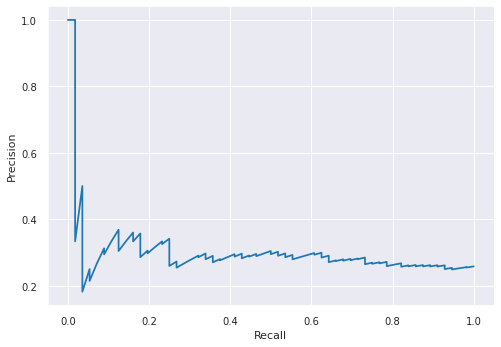

ap_score: 0.30550090175598044
f1_score: 0.08823529411764706
n/Evaluation metrics for disease No_Finding
accuracy: 0.8045454545454546
prevalence: 0.19090909090909092
sensitivity: 0.0
specificity: 0.9943820224719101
ppv: 0.0
npv: 0.8082191780821918
ROC Curve


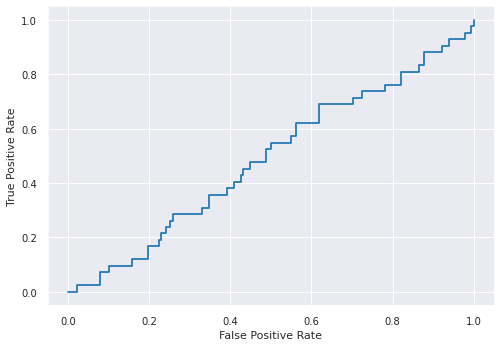

roc_auc: 0.48849652220438733
CI for disease No_Finding roc_auc_score:
0.38899812734082395 0.5951210540395933
PRC Curve


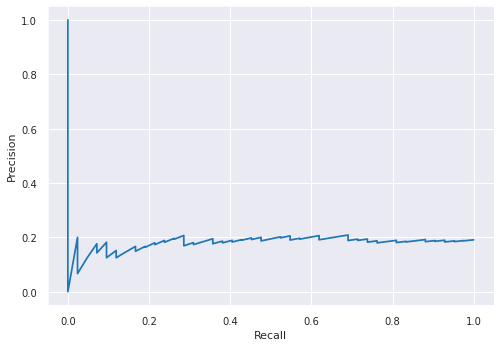

ap_score: 0.1875982528591934
f1_score: nan
n/Evaluation metrics for disease Atelectasis
accuracy: 0.7363636363636363
prevalence: 0.2636363636363636
sensitivity: 0.0
specificity: 1.0
ppv: nan
npv: 0.7363636363636363
ROC Curve


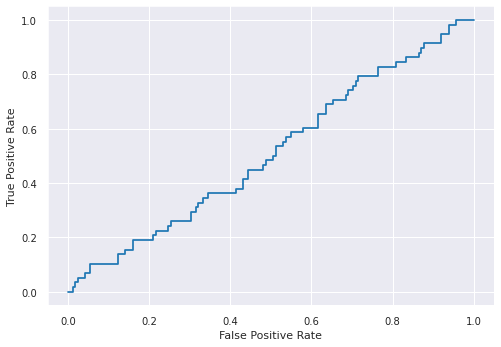

roc_auc: 0.5108556832694764
CI for disease Atelectasis roc_auc_score:
0.41231860515486246 0.5989387047866579
PRC Curve


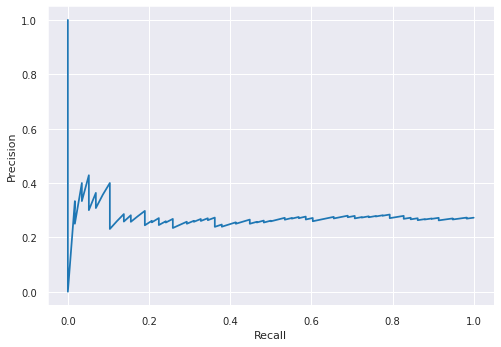

ap_score: 0.2809630840871017
f1_score: nan
n/Evaluation metrics for disease Infiltration
accuracy: 0.6818181818181818
prevalence: 0.3181818181818182
sensitivity: 0.0
specificity: 1.0
ppv: nan
npv: 0.6818181818181818
ROC Curve


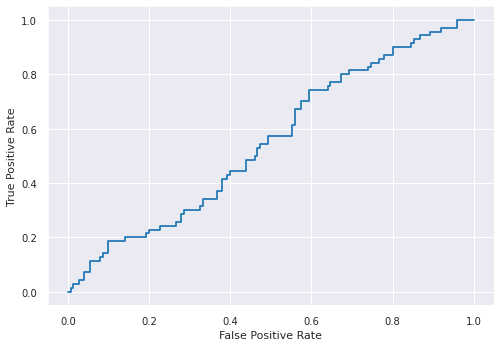

roc_auc: 0.5493333333333333
CI for disease Infiltration roc_auc_score:
0.4748785714285715 0.6338285714285714
PRC Curve


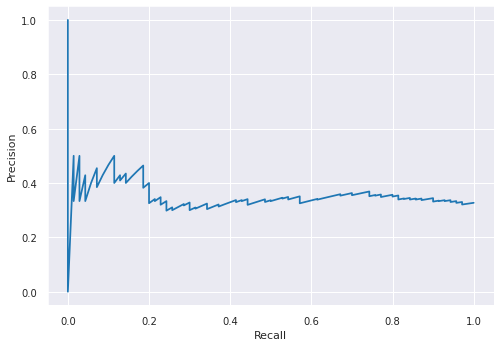

ap_score: 0.36097956589640867
f1_score: nan
n/Evaluation metrics for disease Pneumothorax
accuracy: 0.85
prevalence: 0.15
sensitivity: 0.0
specificity: 1.0
ppv: nan
npv: 0.85
ROC Curve


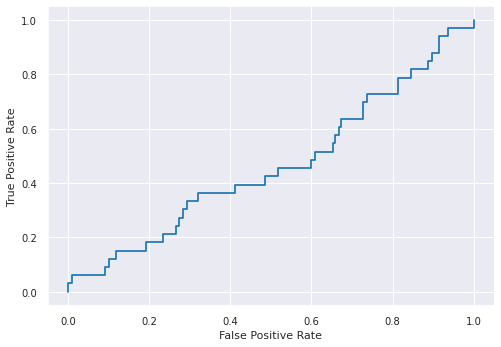

roc_auc: 0.4642683519688867
CI for disease Pneumothorax roc_auc_score:
0.34101037109058496 0.5653459730999838
PRC Curve


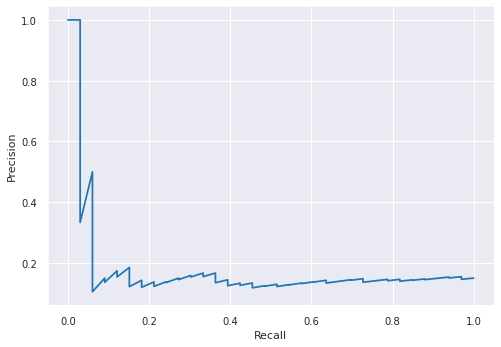

ap_score: 0.1831209113655555
f1_score: nan
n/Evaluation metrics for disease Pneumonia
accuracy: 0.8863636363636364
prevalence: 0.11363636363636363
sensitivity: 0.0
specificity: 1.0
ppv: nan
npv: 0.8863636363636364
ROC Curve


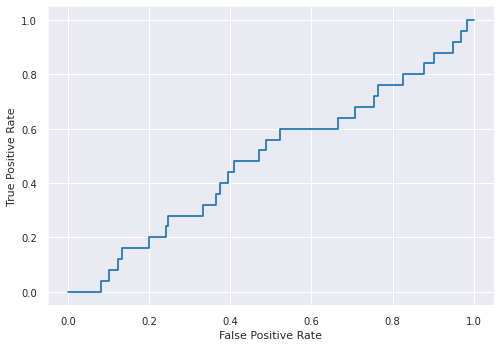

roc_auc: 0.4845128205128205
CI for disease Pneumonia roc_auc_score:
0.3808410256410257 0.613476923076923
PRC Curve


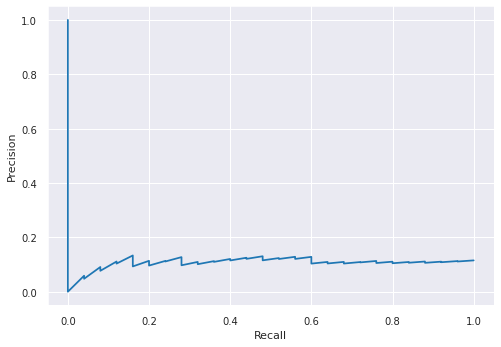

ap_score: 0.11350603129002598
f1_score: nan
n/Evaluation metrics for disease Nodule
accuracy: 0.8454545454545455
prevalence: 0.15454545454545454
sensitivity: 0.0
specificity: 1.0
ppv: nan
npv: 0.8454545454545455
ROC Curve


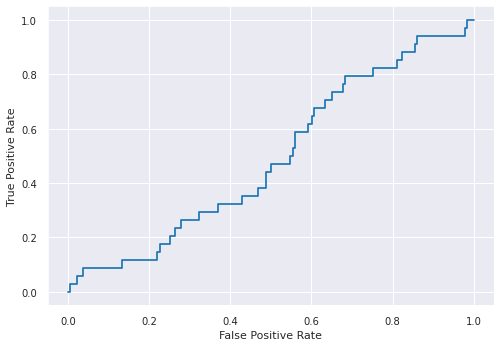

roc_auc: 0.4928842504743833
CI for disease Nodule roc_auc_score:
0.37500790638836184 0.5797912713472486
PRC Curve


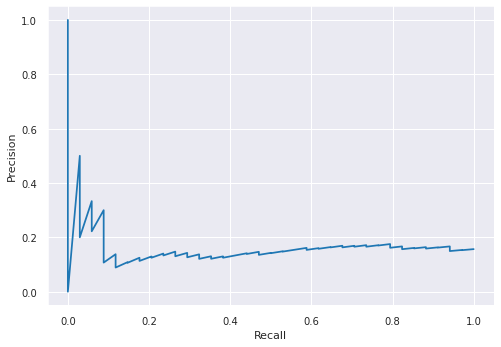

ap_score: 0.17071229597242688
f1_score: nan
n/Evaluation metrics for disease Cardiomegaly
accuracy: 0.8409090909090909
prevalence: 0.1590909090909091
sensitivity: 0.0
specificity: 1.0
ppv: nan
npv: 0.8409090909090909
ROC Curve


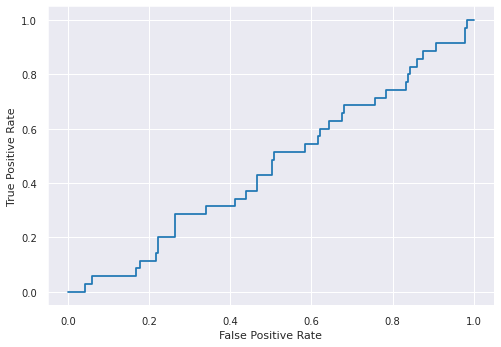

roc_auc: 0.45729729729729723
CI for disease Cardiomegaly roc_auc_score:
0.34954440154440153 0.5586177606177607
PRC Curve


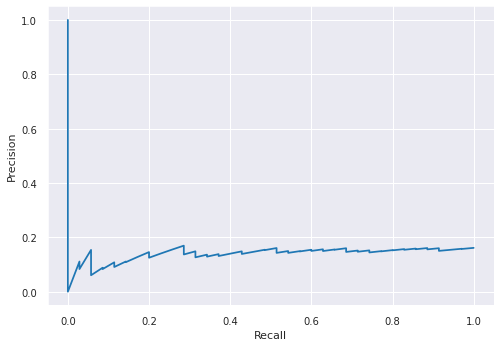

ap_score: 0.146428046409031
f1_score: nan
n/Evaluation metrics for disease Mass
accuracy: 0.9090909090909091
prevalence: 0.09090909090909091
sensitivity: 0.0
specificity: 1.0
ppv: nan
npv: 0.9090909090909091
ROC Curve


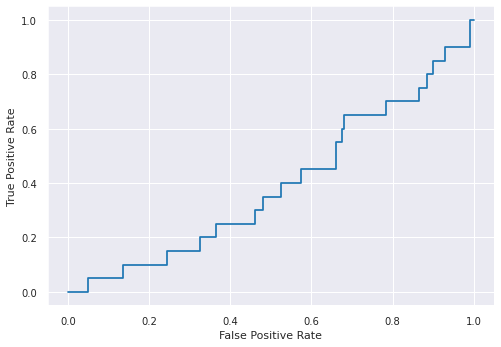

roc_auc: 0.39099999999999996
CI for disease Mass roc_auc_score:
0.2860875 0.5099437499999998
PRC Curve


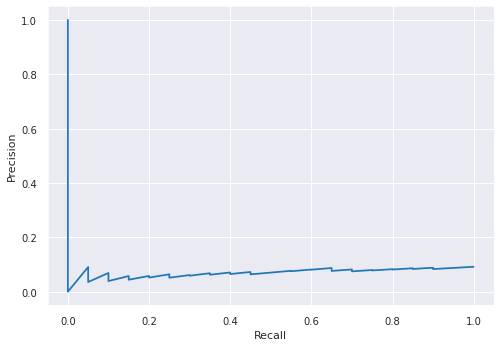

ap_score: 0.0763410204376995
f1_score: nan


In [75]:
threshold = 0.5
for class_label in class_labels:
  class_list.append(class_label)
  metrics_dict['class'] = class_list
  print("n/Evaluation metrics for disease {}".format(class_label))
  accuracy, prevalence, sensitivity, specificity, ppv, npv, roc_auc, ap_score, f1_score = get_performance_metrics(correct_labels_df, pred_df, threshold, class_label)
  accuracy_list.append(accuracy)
  metrics_dict['accuracy'] = accuracy_list
  prevalence_list.append(prevalence)
  metrics_dict['prevalence'] = prevalence_list
  sensitivity_list.append(sensitivity)
  metrics_dict['sensitivity'] = sensitivity_list
  specificity_list.append(specificity)
  metrics_dict['specificity'] = specificity_list
  ppv_list.append(ppv)
  metrics_dict['ppv'] = ppv_list
  npv_list.append(npv)
  metrics_dict['npv'] = npv_list
  roc_auc_list.append(roc_auc)
  metrics_dict['roc_auc'] = roc_auc_list
  ap_score_list.append(ap_score)
  metrics_dict['ap_score'] = ap_score_list
  f1_score_list.append(f1_score)
  metrics_dict['f1_score'] = f1_score_list


In [76]:
metrics_df = pd.DataFrame.from_dict(metrics_dict)
print(metrics_df)

          class  accuracy  prevalence  sensitivity  specificity   ppv  \
0      Effusion  0.718182    0.254545     0.053571     0.945122  0.25   
1    No_Finding  0.804545    0.190909     0.000000     0.994382  0.00   
2   Atelectasis  0.736364    0.263636     0.000000     1.000000   NaN   
3  Infiltration  0.681818    0.318182     0.000000     1.000000   NaN   
4  Pneumothorax  0.850000    0.150000     0.000000     1.000000   NaN   
5     Pneumonia  0.886364    0.113636     0.000000     1.000000   NaN   
6        Nodule  0.845455    0.154545     0.000000     1.000000   NaN   
7  Cardiomegaly  0.840909    0.159091     0.000000     1.000000   NaN   
8          Mass  0.909091    0.090909     0.000000     1.000000   NaN   

        npv   roc_auc  ap_score  f1_score  
0  0.745192  0.548454  0.305501  0.088235  
1  0.808219  0.488497  0.187598       NaN  
2  0.736364  0.510856  0.280963       NaN  
3  0.681818  0.549333  0.360980       NaN  
4  0.850000  0.464268  0.183121       NaN  
5  0.

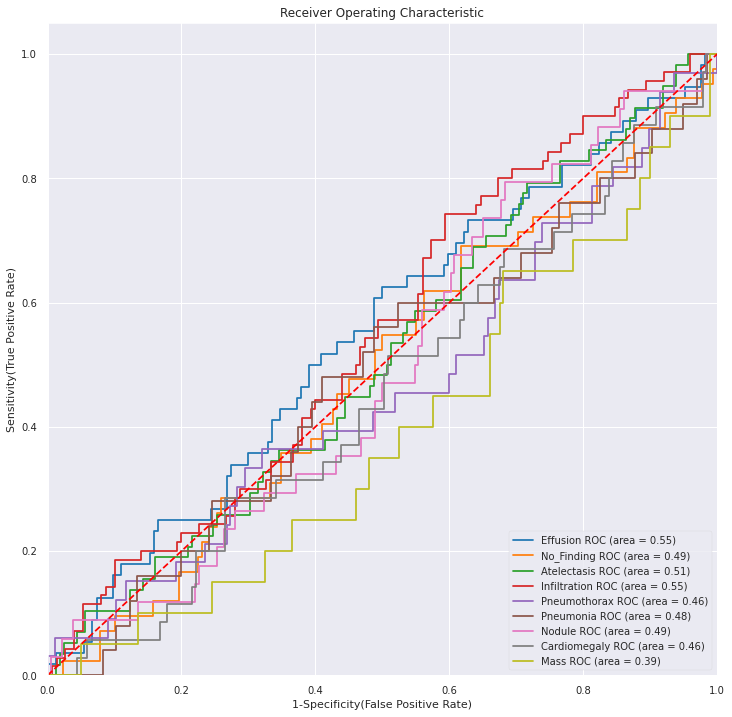

In [82]:
plt.figure(figsize=(12, 12))

for class_label in class_labels:
  y = correct_labels_df[class_label].values
  pred = pred_df[class_label].values
  fpr, tpr, thresholds = sklearn.metrics.roc_curve(y, pred)
  auc = sklearn.metrics.roc_auc_score(y, pred)
  plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (class_label, auc))
# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()   # Display

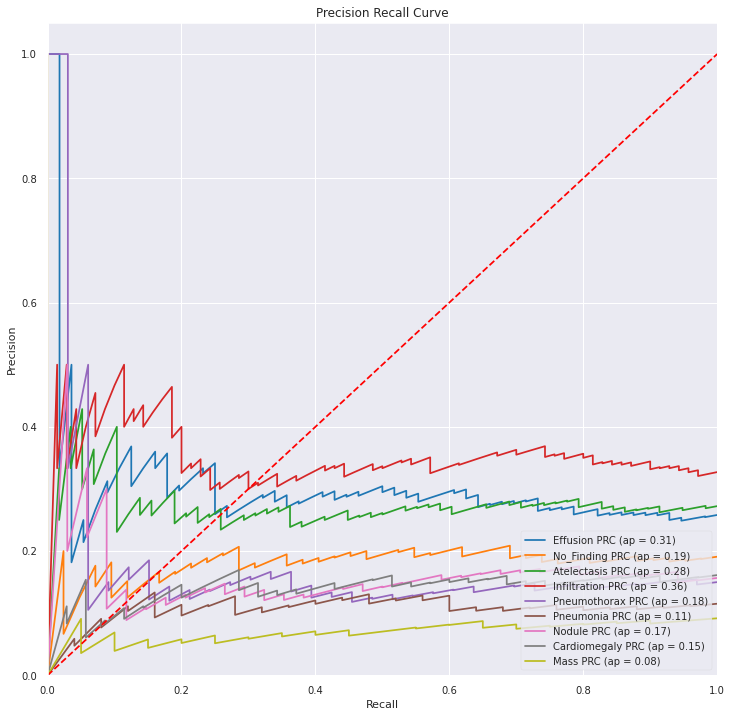

In [83]:
plt.figure(figsize=(12, 12))

for class_label in class_labels:
  y = correct_labels_df[class_label].values
  pred = pred_df[class_label].values
  p, r, t = sklearn.metrics.precision_recall_curve(y, pred)
  ap_score = sklearn.metrics.average_precision_score(y, pred)
  plt.plot(r, p, label='%s PRC (ap = %0.2f)' % (class_label, ap_score))
# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve')
plt.legend(loc="lower right")
plt.show()   # Display

# Layer Visualizations

In [ ]:
# Add code for layer activation visualizations here
